In [58]:
import numpy as np
from numpy import linalg as LA
import time as t
import matplotlib.pyplot as plt
plt.tight_layout()

def randomGaussianArray(length, mu, sigma):
    return np.random.normal(mu, sigma, length)

def randomUniformArray(length, minimum, maximum):
    return np.random.uniform(minimum, maximum,length)

def getBit(intState,i):
    return (intState >> i) & 1

def flipIJ(intState, i, j):
    iBit = getBit(intState,i)
    jBit = getBit(intState,j)
    x = iBit ^ jBit
    x = (x << i) | (x << j)
    return x ^ intState

def binaryStateToIntegerState(binString): 
    return int(binString,2)

def integerStateToBinaryState(intState,length):
    return bin(intState)[2:].zfill(length)

def allowedIntegerStates(length, numParticles): 
    allowedStateSet = []
    startState = 2**numParticles - 1
    allowedStateSet.append(startState)
    endState = startState << (length - numParticles)
    
    iteratorState = startState
    leadingBitPosition = numParticles - 1
    trailingBitPosition = 0

    while(not(iteratorState == endState)):
        if numParticles == 1:
            if (iteratorState >> leadingBitPosition + 1) & 1:
                numParticles += 1
                leadingBitPosition += 1
                continue
            iteratorState = flipIJ(iteratorState, leadingBitPosition, leadingBitPosition + 1)
            leadingBitPosition += 1
            trailingBitPosition += 1
            allowedStateSet.append(iteratorState)
            continue

        if (iteratorState >> leadingBitPosition + 1) & 1:
            numParticles += 1
            leadingBitPosition += 1
            continue

        iteratorState = flipIJ(iteratorState, leadingBitPosition, leadingBitPosition + 1)
        for i in range(leadingBitPosition+1):
            if i<(numParticles-1):
                iteratorState = iteratorState | (1 << i)
            else:
                helper = ((iteratorState >> i) & 1)
                iteratorState = iteratorState ^ (helper << i)

        allowedStateSet.append(iteratorState)
        leadingBitPosition = numParticles - 2
        trailingBitPosition = 0
        numParticles -= 1
    
    return allowedStateSet
    
#conserved up spins (numParticles)
class SpinHalfChainFixed:
    def __init__(self, length, numParticles):
        
        self.length = length
        self.numParticles = numParticles
        self.allowedIntStateBasis = allowedIntegerStates(length,numParticles)
        self.basisDimension = len(self.allowedIntStateBasis)
        
        self.bitFlags = [0]*length
        for i in range(length): 
            self.bitFlags[i] = 2**i
        
        self.allowedStateIndexDictionary = []
        self.initalizeStateIndexDictionary()
        
        self.precomputeSpinZExpectationValues()
        self.createM1()
        
        
    def initalizeStateIndexDictionary(self):
        self.allowedStateIndexDictionary = [self.basisDimension] * (2**self.length)
        i = 0
        for a in self.allowedIntStateBasis:
            self.allowedStateIndexDictionary[a] = i
            i = i+1
    
    def precomputeSpinZExpectationValues(self):
        self.spinZExpectationValues = -0.5*np.ones((self.length,self.basisDimension))
        for i in range(self.length):
            for j in range(self.basisDimension):
                if getBit(self.allowedIntStateBasis[j],i): 
                    self.spinZExpectationValues[i,j] = .05
    
    def createM1(self):
        periodicPosition = np.exp(2j * np.pi * np.arange(self.length) / self.length)
        self.M1 = np.dot(np.transpose(self.spinZExpectationValues),periodicPosition)
    
    def createHeisenbergBaseHamiltonian(self, J):
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        dictionary = self.allowedStateIndexDictionary
        
        ham = np.zeros((dim,dim))
        indA = 0
        for a in allowedStates:
            for i in range(0, length-1):
                j = (i+1)
                
                iBit = getBit(a,i)
                jBit = getBit(a,j)
                
                if iBit == jBit:
                    ham[indA,indA] += (J * 0.25)
                else: 
                    ham[indA,indA] -= (J * 0.25)
                    b = flipIJ(a,i,j)
                    indB = dictionary[b]
                    ham[indA,indB] += (J * 0.25)
                    ham[indB,indA] += (J * 0.25)
            indA += 1
        return ham

    def HeisenbergDisorderInstance(self,h): 
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        zExpec = self.spinZExpectationValues
    
        wi = randomUniformArray(length, -h, h)
        dis = np.zeros((dim,dim))
        
        indA = 0
        for a in allowedStates:
            binStateList = zExpec[:,indA]
            dis[indA,indA] += np.dot(binStateList,wi)
            indA += 1
        return dis
    
    def specificHeisenbergDisorderInstance(self,harray): 
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        zExpec = self.spinZExpectationValues
    
        wi = harray
        dis = np.zeros((dim,dim))
        
        indA = 0
        for a in allowedStates:
            binStateList = zExpec[:,indA]
            dis[indA,indA] += np.dot(binStateList,wi)
            indA += 1
        return dis
    
    
    def CorrFunct(self, nsq, site1, site2):
        S1 = self.spinZExpectationValues[site1,:]
        S2 = self.spinZExpectationValues[site2,:]
        return np.dot(np.multiply(S1,S2),nsq) - np.dot(S1,nsq)*np.dot(S2,nsq)
    
    
def figure2(Lvals,hvals,dvals):
    Fvals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        M1sq = np.multiply(np.conj(chain.M1),chain.M1)
        for j in range(len(hvals)):
            for d in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for k in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,k],E[1][:,k])
                    halftop = np.dot(chain.M1,nsq)
                    Fvals[i,j] += (1 - ((halftop.real*halftop.real + halftop.imag*halftop.imag)/(np.dot(M1sq, nsq).real)))/((chain.basisDimension//3) *dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Fvals

def figure4(Lvals,hvals,dvals):
    Cvals = np.zeros((len(hvals),len(Lvals),Lvals[-1]//2))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for site in range(Lvals[i]):
                        for d in range(1,min(Lvals[i]//2+1,Lvals[i]-site)):
                            Cvals[j,i,d-1] += chain.CorrFunct(nsq,site,(site+d))/((chain.basisDimension//3)*Lvals[i]*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Cvals

def figure56(Lvals,hvals,dvals):
    Cvals = np.zeros((len(Lvals),len(hvals),1))
    Cvals = Cvals.tolist()
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for site in range(Lvals[i]//2):
                        Cvals[i][j].append(np.log(np.absolute(chain.CorrFunct(nsq,site,(site+Lvals[i]//2)))))
            del Cvals[i][j][0]
            print("h = " + str(hvals[j]) + " finished.")
    return np.array(Cvals)
    
def getEnergies(ham):
    return LA.eigvalsh(ham)

def getEnergyGaps(ham):
    eList = getEnergies(ham)
    return np.diff(eList)

def getRValues(ham):
    rValues = []
    eDiff = getEnergyGaps(ham)
    for i in range(1,len(eDiff)): 
        n = eDiff[i]
        m = eDiff[i-1]
        maximum = max(n,m)
        minimum = min(n,m)
        rValues.append(minimum/maximum)
    return rValues
        

def averageR(ham): 
    rValues = getRValues(ham)
    return np.mean(rValues)

def BipartEntangleS(Lvals, hvals, dvals):
    Svals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension):
                    #this part gets complicated but I hope it saves time over using a for loop
                    halfrhoa = np.zeros(2**(Lvals[i]//2))
                    
                    #lambdas don't allow assignment so I need to create this
                    #and since halfrhoa is created here, we need to create the
                    #function every time
                    def helper(x):
                        halfrhoa[int(x[0])] += x[1]
                    
                    #adds on the eigenstate weighting, E[1][:,n], to the position in list rhoa corresponding to
                    #the integer value that represents the respective reduced subspace for the basis element
                    #which is incapsulated in np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2) as we bit
                    #shift to eliminate one of the halves of the system for each of the states in order.
                    np.apply_along_axis(helper,1,np.dstack((np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2),E[1][:,n]))[0])
                    #axis 1 is chosen because of the way np.dstack creates the tuples (np.dstack is essentially zip)
                    
                    #there's only integer weighting so I don't need to conjugate
                    #also our density matrix is diagonal, so we can simplify the computation
                    rhoa = np.multiply(halfrhoa,halfrhoa)
                    
                    if(min(rhoa)==0):
                        print("y")
                    Svals[i][j] -= np.dot(rhoa,np.log(rhoa))/((chain.basisDimension)*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Svals

def BipartIPR(Lvals, hvals, dvals):
    IPRvals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        L = Lvals[i]
        chain = SpinHalfChainFixed(L, L//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                #this list of disorder values will be used multiple times
                wi = randomUniformArray(L, -hvals[j], hvals[j])
                #just setting up the full chain H as usual
                H = Hbase + chain.specificHeisenbergDisorderInstance(wi)
                E = LA.eigh(H)
                #here we pick a distribution of particles on L and R that's faithful to the original
                #distribution of particles given the fixed particle number.
                initialRandConfig = chain.allowedIntStateBasis[np.random.randint(len(chain.allowedIntStateBasis))]
                ###print(integerStateToBinaryState(initialRandConfig,L))
                Linit = initialRandConfig >> L//2
                ###print(Linit)
                Rinit = initialRandConfig - (Linit << L//2)
                ####print(Rinit)
                Lparticles = 0
                Rparticles = 0
                for n in range(Lvals[i]//2):
                    if (Linit >> n)&1:
                        Lparticles +=1
                    if (Rinit >> n)&1:
                        Rparticles +=1
                #given this distribution, we now need to pick random eigenstates from each side
                chainL = SpinHalfChainFixed(L//2, Lparticles)
                ###print(Lparticles)
                chainR = SpinHalfChainFixed(L//2, Rparticles)
                ###print(Rparticles)
                #here you see why we need to reuse the disordered onsite field values
                HL = chainL.createHeisenbergBaseHamiltonian(1) + chainL.specificHeisenbergDisorderInstance(wi[L//2:L])
                HR = chainR.createHeisenbergBaseHamiltonian(1) + chainR.specificHeisenbergDisorderInstance(wi[0:L//2])
                EL = LA.eigh(HL)
                ER = LA.eigh(HL)
                ###print(EL[1])
                ###print(ER[1])
                ###print(chainL.basisDimension)
                ###print(chainR.basisDimension)
                Lstate = EL[1][:,np.random.randint(chainL.basisDimension)]
                Rstate = ER[1][:,np.random.randint(chainR.basisDimension)]
                
                ###print(Lstate)
                ###print(Rstate)
                
                #with a random state picked, we can now do the pullback to LR
                
                #first we do the same thing as in bipartite entanglement for finding the full -> L or R map
                Lmap = np.right_shift(chain.allowedIntStateBasis,L//2)
                ###print(Lmap)
                ###print(chainL.allowedStateIndexDictionary)
                Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,L//2)
                ###print(Rmap)
                ###print(chainR.allowedStateIndexDictionary)
                #and then map things together
                combinedState = np.zeros(chain.basisDimension)
                for n in range(chain.basisDimension):
                    tempL = chainL.allowedStateIndexDictionary[Lmap[n]]
                    tempR = chainR.allowedStateIndexDictionary[Rmap[n]]
                    if (tempL<chainL.basisDimension)&(tempR<chainR.basisDimension):
                        combinedState[n] = Lstate[tempL]*Rstate[tempR]
                
                #now we can calculate and save the IPR value
                ###print(combinedState)
                ###print(E[1])
                ###print(np.dot(combinedState,E[1]))
                ###print(sum((np.dot(combinedState,E[1]))**4))
                IPRvals[i][j] += (sum((np.dot(combinedState,E[1]))**4)*dvals[i])**(-1)
            print("h = " + str(hvals[j]) + " finished.")
    return IPRvals


In [ ]:
hlist = [.2,1,2,3.5,5,8,12]
temp = t.clock()
f2 = figure2([8,10,12],hlist,[5000,500,50])
print(t.clock()-temp)
out, sub = plt.subplots(1)
sub.semilogx(hlist,f2[0],basex=5)
sub.semilogx(hlist,f2[1],basex=5)
sub.semilogx(hlist,f2[2],basex=5)
#sub.semilogx(hlist,f[3],basex=5)
#sub.semilogx(hlist,f[4],basex=5)
#sub.semilogx(hlist,f[5],basex=5)

In [ ]:
Llist = [8,10,12,14]
temp = t.clock() 
f4 = figure4(Llist,[.5,8],[200,50,10,4])
print(t.clock()-temp)

In [ ]:
out,sub = plt.subplots(1)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[0,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[0,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[0,2],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[3]//2+1), np.absolute(np.trim_zeros(f4[0,3],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[1,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[1,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[1,2],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[3]//2+1), np.absolute(np.trim_zeros(f4[1,3],trim='b')), basey = np.e)

In [ ]:
Llist = [8,10,12]
hlist = [2,4.5,6.5,8,10,14,20,26]
dlist = [1000,300,100]
temp = t.clock()
f56 = figure56(Llist,hlist,dlist)
print(t.clock()-temp)

In [ ]:
out0,sub0 = plt.subplots(1)
sub0.hist(f56[0][0],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][1],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][2],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][3],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][4],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][5],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][6],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][7],density='true',histtype = 'step',bins = 30)
out1,sub1 = plt.subplots(1)
sub1.hist(f56[1][0],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][1],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][2],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][3],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][4],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][5],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][6],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][7],density='true',histtype = 'step',bins = 30)
out2,sub2 = plt.subplots(1)
sub2.hist(f56[2][0],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][1],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][2],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][3],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][4],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][5],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][6],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][7],density='true',histtype = 'step',bins = 30)

In [ ]:
f6 = np.zeros((len(Llist), len(hlist)))
for i in range(len(Llist)):
    for j in range(len(hlist)):
        f6[i,j] = np.std(np.divide(f56[i][j],np.average(f56[i][j])))
out, sub = plt.subplots(1)
sub.semilogx(hlist, f6[0],basex=5)
sub.semilogx(hlist, f6[1],basex=5)
sub.semilogx(hlist, f6[2],basex=5)

In [56]:
hlist = [12]
temp = t.clock()
SerbynAbanin1 = BipartEntangleS([12],hlist,[100])
print(t.clock()-temp)

L = 12 started.
3.1573322228612436e-41
9.725049352617825e-48
2.552588300603524e-34
2.1527438703071865e-40
2.2134755250887575e-42
2.911728629182e-42
2.891863695365656e-33
1.4360590663289719e-35
3.2074777757665565e-33
1.9696426205538875e-45
4.220955951519294e-42
2.5210014739964417e-32
1.176466252667879e-33
1.0262824723578728e-37
3.16216096569868e-39
1.677052620026279e-33
2.6629815620705317e-35
5.429359510826265e-31
1.0978547403536966e-38
2.061222561344926e-30
1.7275146872553478e-35
1.162207355828659e-33
2.4568346048993763e-39
1.42669462734753e-39
1.437260755705367e-41
8.708539318781184e-39
6.156679049150111e-31
7.508849678050072e-40
3.0267501799996483e-48
1.6799951617978624e-33
1.2936521368507717e-30
5.1473799755210045e-33
5.5985391360178456e-33
1.8946487625224674e-32
3.202045748232683e-35
9.670157944448888e-38
9.683294184974822e-38
5.972775515244225e-35
2.345633442400207e-41
5.061619926657343e-36
1.918839614065426e-33
6.9756228490395675e-28
3.768604119552723e-33
1.3792200068179903e-40
3

4.837985130726137e-27
4.816985153409008e-29
1.8049058533858927e-36
7.374803521202796e-29
6.256686260631672e-40
1.6103068092442862e-31
5.464310839281497e-31
1.0721930558893364e-24
2.3854480630032655e-27
1.3706459919948629e-25
7.7531727210886e-45
2.0265976234119307e-25
2.2804948788792003e-28
2.121259920732063e-31
1.174039313948687e-25
4.472088028846788e-27
2.6755075767200774e-26
5.255656253899469e-28
1.3251573363640253e-30
1.0666960797701107e-34
5.115547711084339e-31
7.439798884127096e-29
2.310508428422377e-27
3.1318128929997695e-28
1.1592550983979857e-31
1.5598050991578733e-32
8.703371532255242e-35
1.0048815349890084e-27
6.216397593097628e-28
2.5052340514768908e-36
9.222840239484816e-40
1.1165886399244427e-34
2.815816362127532e-30
7.277356976439744e-32
1.5220691586138571e-28
7.363405463534293e-35
3.988175948610823e-33
9.883066934288674e-31
1.3505679917793944e-26
7.364952217350379e-35
9.317912360211413e-40
1.776916678331638e-32
1.2193295914988314e-25
3.254080025913147e-25
1.1053731289738

2.7241237638245275e-25
1.3129069378032231e-25
9.956130428421872e-43
1.2402619621562225e-34
2.852836712854811e-42
3.031115104739542e-36
2.9031485433149332e-28
3.87773605114985e-44
8.46010943978283e-28
1.5080298466543492e-26
1.0189581131767767e-41
1.9494145148280726e-29
3.556477967371896e-37
1.0375175861904247e-28
2.1215895369831845e-26
2.3122818144977875e-31
5.7334375795447664e-36
1.331515739059118e-35
5.069372929368925e-25
4.5350823916940235e-34
1.58100319877066e-29
1.937094359010772e-27
7.451712501206881e-34
5.791142498154893e-36
3.1968719765049e-33
4.494491662842994e-33
9.751314661649209e-33
2.4419330948377622e-30
1.0199356476365419e-32
3.1442291549925875e-33
4.594797273057018e-33
5.684828957288724e-42
8.18304673259395e-28
1.3323477934692647e-35
2.342357193016561e-34
3.474194412812786e-34
1.1216090758191097e-42
3.130851791755642e-45
1.7556252953477112e-39
6.94918670456328e-32
9.707725178764146e-29
5.864276843646449e-31
7.58553056730765e-54
1.3925843046700557e-29
8.394191799172427e-30

1.0484681472267135e-24
3.504560259630961e-20
2.7717024526163097e-27
6.309886675648959e-23
1.3784321957679641e-24
2.632326687521986e-23
2.1857843385872626e-21
2.5151087512825913e-29
5.067731036250387e-23
1.7983778607155466e-30
9.079471186462776e-22
3.2202985528589226e-22
1.0925724650470296e-23
3.6810086584036507e-25
8.969856011509816e-29
8.652385071467085e-22
2.375739183707511e-21
5.481923360652339e-23
5.973502349806666e-29
1.2806564840347742e-29
6.36077167714414e-28
7.933996038393324e-22
1.678959205242275e-26
2.5113621339107076e-23
1.339641212842605e-22
1.7706880334945438e-25
1.500857469381921e-25
1.809777714306624e-24
1.2912131382453708e-21
1.4733743227841214e-25
3.1598266324870156e-30
1.6325658546239664e-22
2.9412293353882795e-25
1.5720152202811836e-21
3.975967725287023e-26
2.6773124563942106e-21
7.911468457000857e-21
1.2487782430287342e-25
2.801664301992774e-31
1.996932956853758e-30
1.7215023274607393e-20
8.458011727268558e-33
1.0252128756684721e-26
4.12505386170815e-24
3.5801754837

3.8954076037947944e-25
2.2619086123403157e-28
2.6326323494792913e-28
8.865539814470972e-29
9.855036717847508e-25
1.0421339361622418e-24
6.970604303052215e-29
3.0002749988338126e-25
7.389469449032913e-25
4.227385694213338e-28
1.2238626252100692e-29
2.7485011155378083e-31
1.259271215929252e-29
1.6509031596019033e-23
7.613203576076097e-27
1.034185334560219e-29
1.5757979612213563e-22
4.658479863456084e-25
8.857026305725185e-22
4.803894802320507e-25
4.61365681173975e-24
6.961904439354104e-23
4.124481154058053e-21
1.454228377618127e-20
1.9774105168718646e-22
1.1437152723736726e-27
3.8950770936318974e-28
9.352767950498814e-34
9.390761255434724e-26
3.726417400005801e-26
1.9753503866047458e-22
4.061103783751851e-22
1.5722363546811657e-26
1.6428543665426813e-23
4.3383344630488145e-28
8.217169911235536e-22
2.7828497531881133e-25
7.611938709666545e-24
1.243909651180213e-23
1.693899448449537e-25
2.0829518984247403e-30
4.060929467227118e-26
9.721354841527866e-25
5.141960376147128e-25
6.9894293829739

4.497361838724852e-44
8.270046735097875e-33
4.960926163192518e-35
1.1210208096569779e-32
7.979649149120964e-30
9.165480811049429e-34
6.62661982023696e-41
4.23002425019201e-36
4.366504535180579e-34
2.8445464534037736e-33
5.245258820108413e-38
7.130763188116415e-35
2.7523574082679314e-37
3.1432366491323995e-48
4.566352011610767e-35
1.4151219199689202e-34
1.1117573111505607e-33
7.817887448933847e-34
8.93708249531142e-33
1.708567512054616e-31
2.877398200242195e-39
8.078439710019403e-36
1.9562151847787364e-33
1.3066272006325679e-40
7.8465695849877e-38
5.639666508364446e-37
7.958998037978641e-34
2.322624404878967e-36
5.7769013609402386e-49
2.6186867421753584e-34
1.1636791701122444e-34
2.749746996085085e-42
8.419241748064812e-36
1.1790020289176717e-36
7.392270362699735e-42
1.4366462303085807e-31
5.687813057232132e-33
6.749286361394672e-33
9.062733360908053e-33
4.709912752204288e-33
8.24956991857893e-33
6.429282965795993e-43
4.651611005294627e-36
2.0013908635321004e-37
1.7453278432337912e-35
6

KeyboardInterrupt: 

In [ ]:
out,sub = plt.subplots(1)
sub.plot(hlist,SerbynAbanin1[0])
#sub.plot(hlist,SerbynAbanin1[1])
#sub.plot(hlist,SerbynAbanin1[2])
#sub.plot(hlist,SerbynAbanin1[3])

In [64]:
hlist = [1,2,3,5,8]
temp = t.clock()
SerbynAbanin2 = BipartIPR([8,10,12,14],hlist,[20000,2000,200,100])
print(t.clock()-temp)

L = 8 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 10 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 12 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 14 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
3535.3765962678735


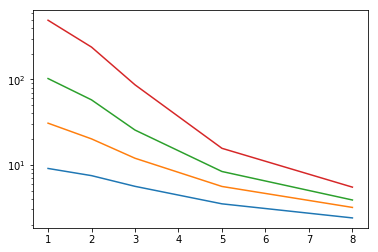

In [65]:
out,sub = plt.subplots(1)
sub.semilogy(hlist,SerbynAbanin2[0],basey=10)
sub.semilogy(hlist,SerbynAbanin2[1],basey=10)
sub.semilogy(hlist,SerbynAbanin2[2],basey=10)
sub.semilogy(hlist,SerbynAbanin2[3],basey=10)